# Depression Analysis Notebook

This notebook performs EDA, preprocessing (imputation, scaling, encoding), and regression modeling to predict the target variable `Depression`. 
We split the single dataset into training and testing sets. 

A custom transformer, `RareCategoryGrouper`, is used in the categorical pipeline to group infrequent categories into a common label "Rare" in order to reduce warnings about unknown categories during transformation and potentially improve model performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline

import warnings
# Optionally, you can filter warnings (if desired) 
# warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._encoders")

## 0. Load Data and Remove Irrelevant Columns

Load the dataset (adjust the file path as needed) and remove irrelevant columns (e.g., `Name`, `Id`, `CGPA`).

In [2]:
# Load the dataset
train_df = pd.read_csv('./data/train.csv')

# List of irrelevant columns to remove
irrelevant_cols = ['Name', 'id', ]

# Drop the irrelevant columns
train_df = train_df.drop(columns=irrelevant_cols, errors='ignore')

print("Data after removing irrelevant columns:")
print(train_df.head())

Data after removing irrelevant columns:
   Gender   Age           City Working Professional or Student  \
0  Female  49.0       Ludhiana            Working Professional   
1    Male  26.0       Varanasi            Working Professional   
2    Male  33.0  Visakhapatnam                         Student   
3    Male  22.0         Mumbai            Working Professional   
4  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN         

## 1. Exploratory Data Analysis (EDA)

Display basic info, summary statistics, missing values, and visualize distributions.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   City                                   140700 non-null  object 
 3   Working Professional or Student        140700 non-null  object 
 4   Profession                             104070 non-null  object 
 5   Academic Pressure                      27897 non-null   float64
 6   Work Pressure                          112782 non-null  float64
 7   CGPA                                   27898 non-null   float64
 8   Study Satisfaction                     27897 non-null   float64
 9   Job Satisfaction                       112790 non-null  float64
 10  Sleep Duration                     

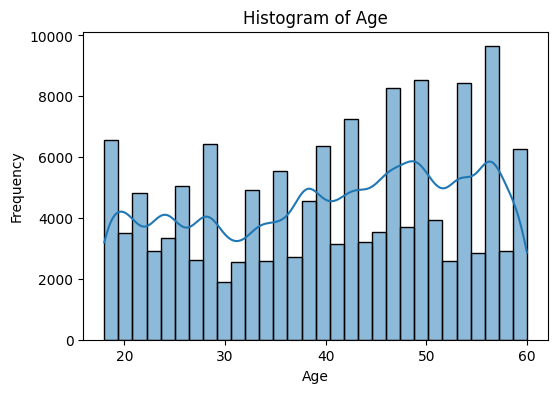

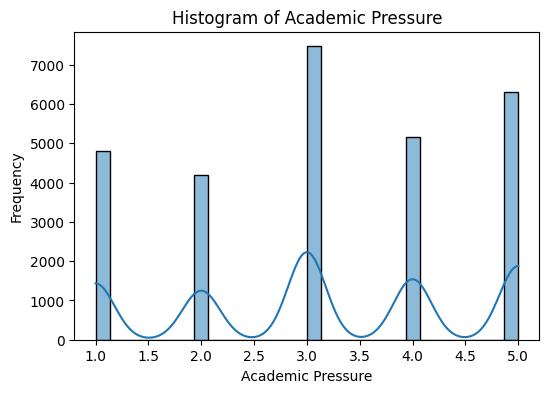

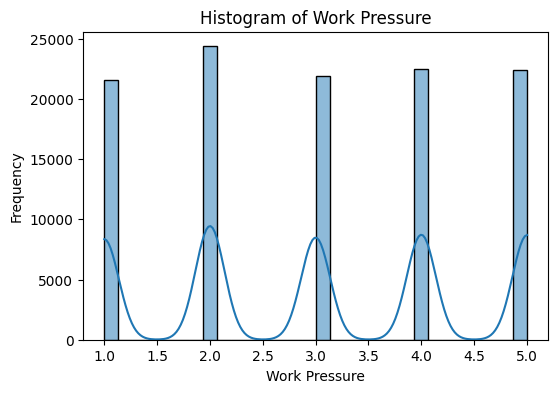

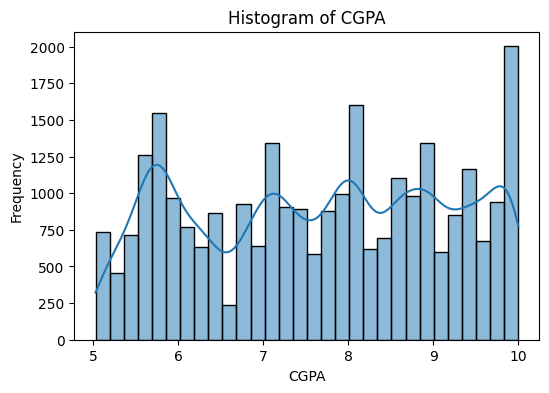

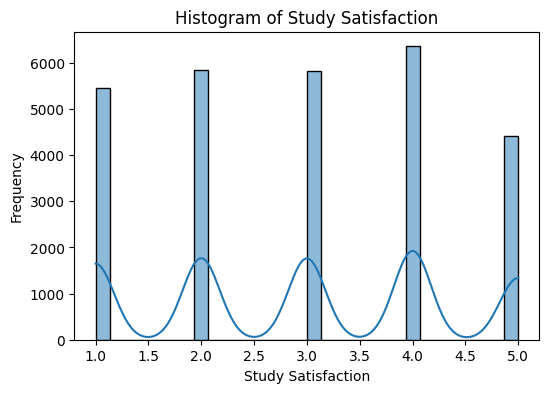

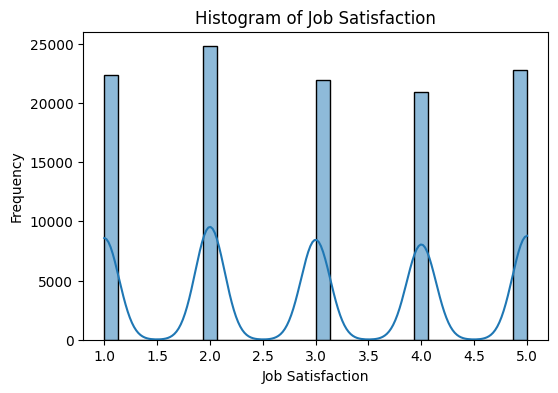

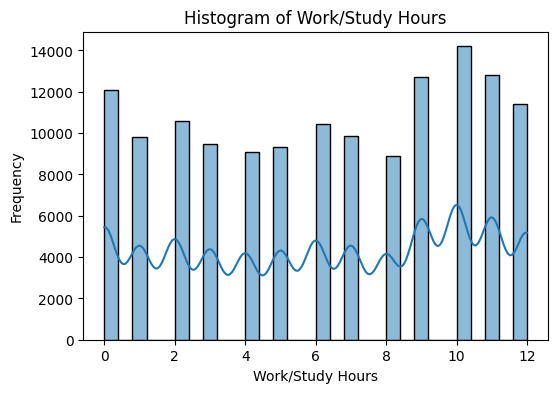

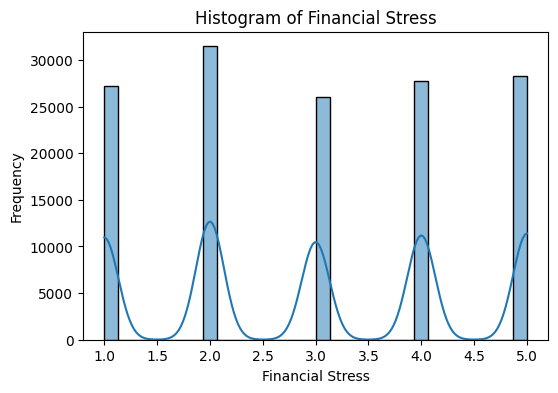

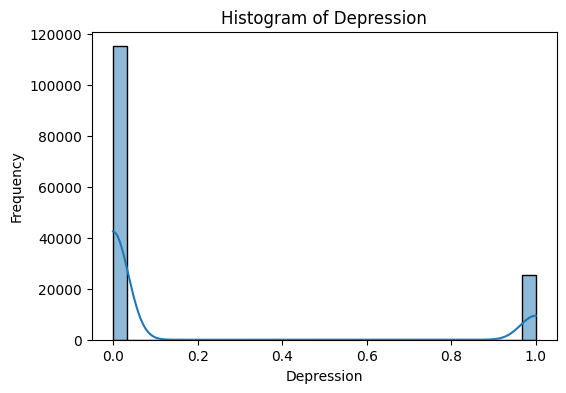

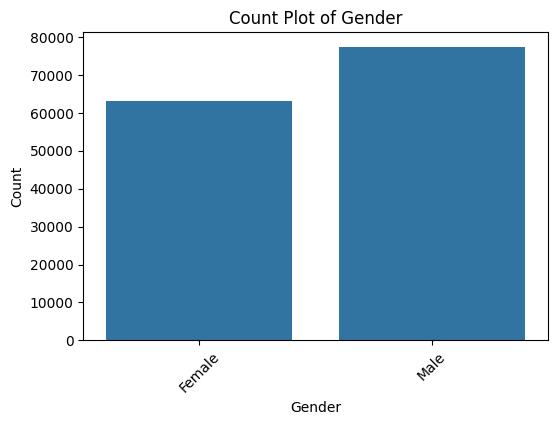

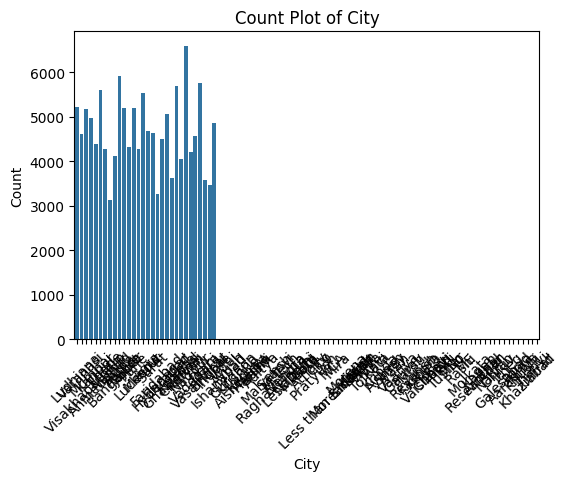

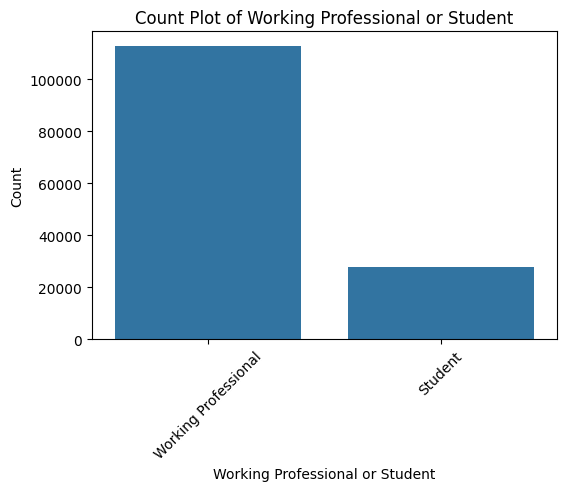

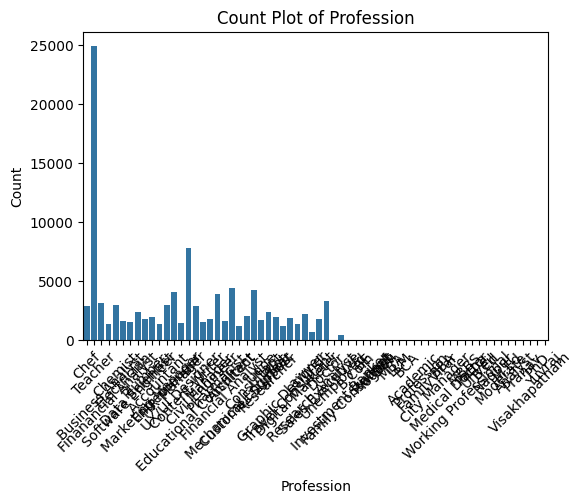

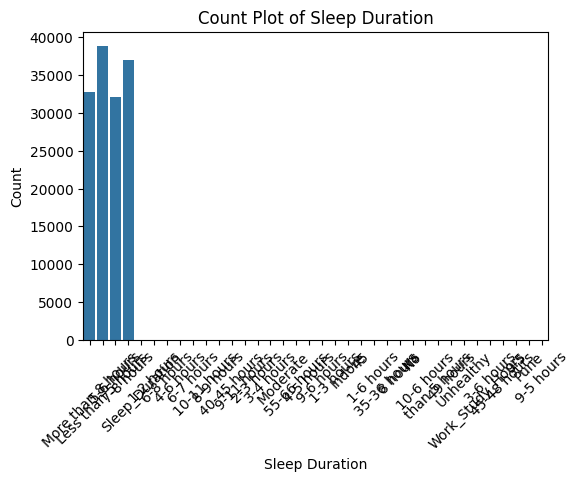

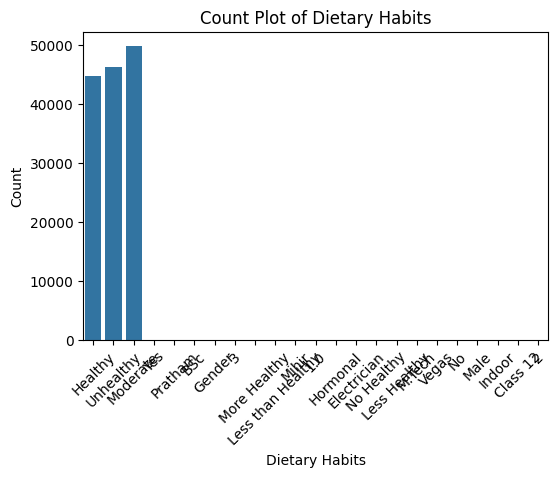

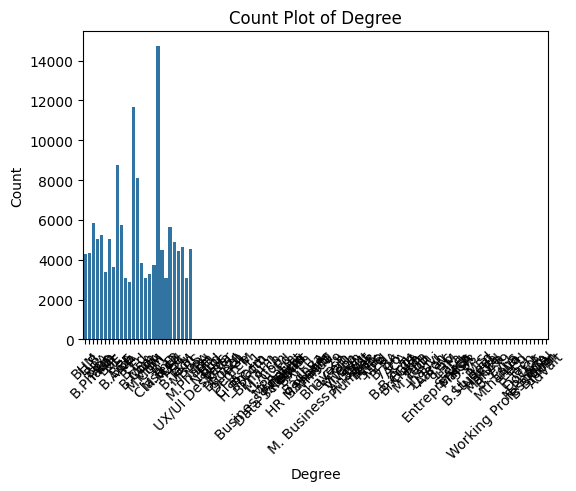

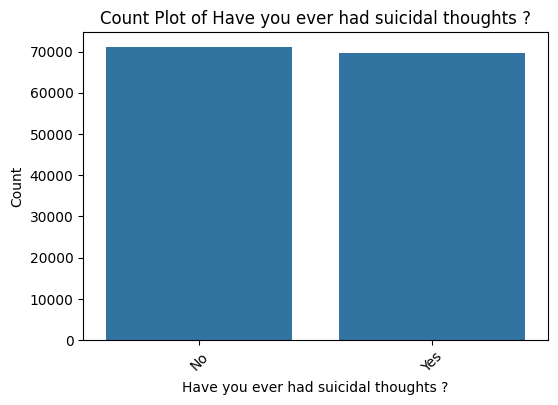

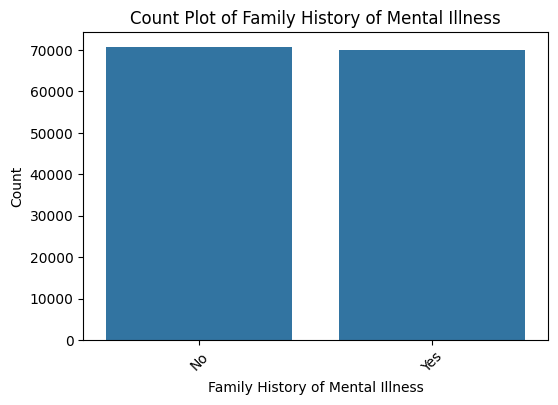

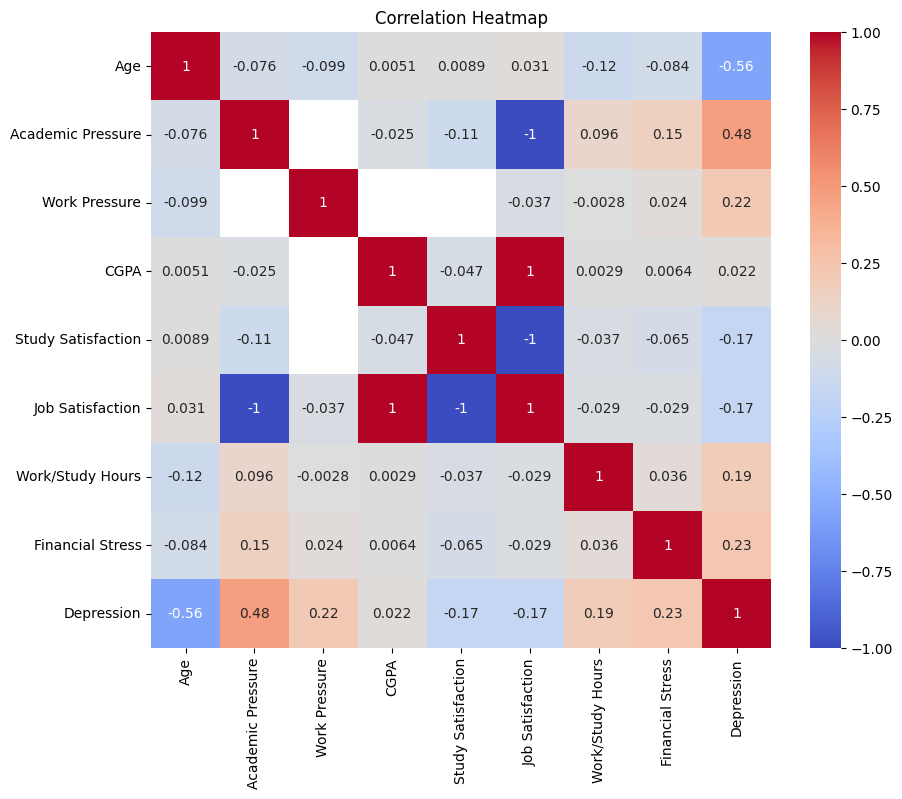

In [3]:
print("Dataset Information:")
print(train_df.info())

print("\nSummary Statistics:")
print(train_df.describe())

print("\nMissing Values per Column:")
print(train_df.isnull().sum())

# Identify numerical and categorical columns
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print("\nNumerical columns:", num_cols)
print("Categorical columns:", cat_cols)

# Histograms for numerical features
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Count plots for categorical features
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=train_df[col])
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## 2. Train/Test Split

Since the dataset only contains training data (with the target `Depression`), we split it into training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split

target = "Depression"
if target not in train_df.columns:
    raise ValueError(f"Target column '{target}' not found in the dataset.")

X = train_df.drop(columns=[target])
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (112560, 17)
Testing set shape: (28140, 17)


## 3. Preprocessing Pipeline (Imputation, Scaling, and Encoding)

We create pipelines for numerical and categorical features. 
A custom transformer (`RareCategoryGrouper`) is added to group rare categories into the label "Rare" before one-hot encoding, reducing unknown category issues.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    A custom transformer that groups rare categories in each categorical column into a single label "Rare".
    The parameter `min_frequency` defines the minimum frequency count for a category to be kept.
    """
    def __init__(self, min_frequency=100):
        self.min_frequency = min_frequency
        self.common_categories_ = {}
    def fit(self, X, y=None):
        # X is expected to be a DataFrame
        for col in X.columns:
            freq = X[col].value_counts()
            common = freq[freq >= self.min_frequency].index.tolist()
            self.common_categories_[col] = set(common)
        return self
    def transform(self, X):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            if X_transformed[col].dtype == 'object':
                common = self.common_categories_.get(col, set())
                X_transformed[col] = X_transformed[col].apply(lambda x: x if x in common else 'Rare')
        return X_transformed

# Recompute column lists from X_train (target not included)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical features: impute with median, then scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features: group rare categories, impute, then one-hot encode
cat_transformer = Pipeline(steps=[
    ('rare', RareCategoryGrouper(min_frequency=100)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

## 4. Model Building and Evaluation

We build several baseline regression models using a pipeline that includes preprocessing and evaluate them on the test set.

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def create_pipeline(model):
    return Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    pipe = create_pipeline(model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"\n{name} Results:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R^2 Score: {r2:.4f}")


Linear Regression Results:
  Mean Squared Error: 0.0655
  R^2 Score: 0.5619

Ridge Regression Results:
  Mean Squared Error: 0.0655
  R^2 Score: 0.5619

Lasso Regression Results:
  Mean Squared Error: 0.1496
  R^2 Score: -0.0000

Decision Tree Results:
  Mean Squared Error: 0.0916
  R^2 Score: 0.3874

Random Forest Results:
  Mean Squared Error: 0.0491
  R^2 Score: 0.6721

Gradient Boosting Results:
  Mean Squared Error: 0.0483
  R^2 Score: 0.6771


## 5. Hyperparameter Tuning for Tree-based Models

Use GridSearchCV to tune hyperparameters for Random Forest and Gradient Boosting.

In [7]:
from sklearn.model_selection import GridSearchCV

# Tuning Random Forest
rf_pipeline = create_pipeline(RandomForestRegressor(random_state=42))
rf_param_grid = {
    'model__n_estimators': [100, 200],  # Reduced from [100, 200, 300]
    'model__max_depth': [10, 20],       # Reduced from [None, 10, 20, 30]
    'model__min_samples_split': [2, 5]   # Reduced from [2, 5, 10]
}
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
print("Tuned Random Forest Results:")
print("  Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))
print("  R^2 Score:", r2_score(y_test, y_pred_rf))

# Tuning Gradient Boosting
gb_pipeline = create_pipeline(GradientBoostingRegressor(random_state=42))
gb_param_grid = {
    'model__n_estimators': [100, 200],     # Reduced from [100, 200, 300]
    'model__learning_rate': [0.01, 0.1],    # Reduced from [0.01, 0.05, 0.1]
    'model__max_depth': [3, 5]              # Reduced from [3, 5, 7]
}
gb_grid = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
print("\nGradient Boosting Best Parameters:", gb_grid.best_params_)
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test)
print("Tuned Gradient Boosting Results:")
print("  Mean Squared Error:", mean_squared_error(y_test, y_pred_gb))
print("  R^2 Score:", r2_score(y_test, y_pred_gb))


Random Forest Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Tuned Random Forest Results:
  Mean Squared Error: 0.04796190621602853
  R^2 Score: 0.6794197190682394

Gradient Boosting Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Tuned Gradient Boosting Results:
  Mean Squared Error: 0.046409859782082286
  R^2 Score: 0.6897936912696891


## 6. Residual Analysis (Optional)

Plot residuals for the tuned Random Forest and Gradient Boosting models.

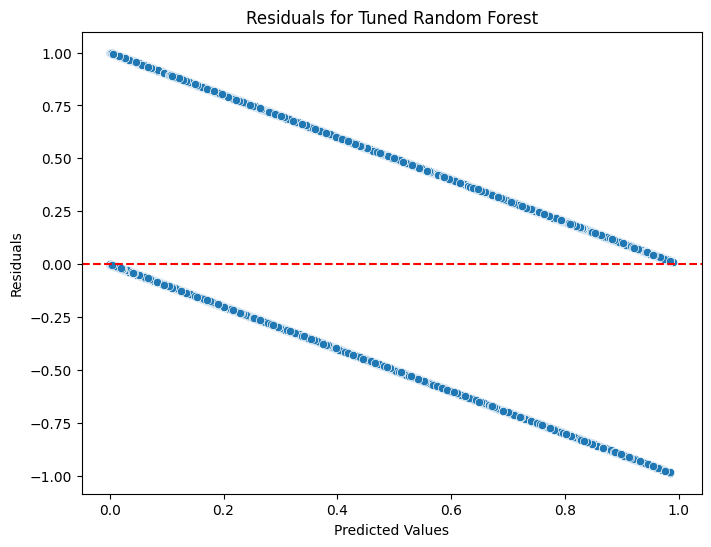

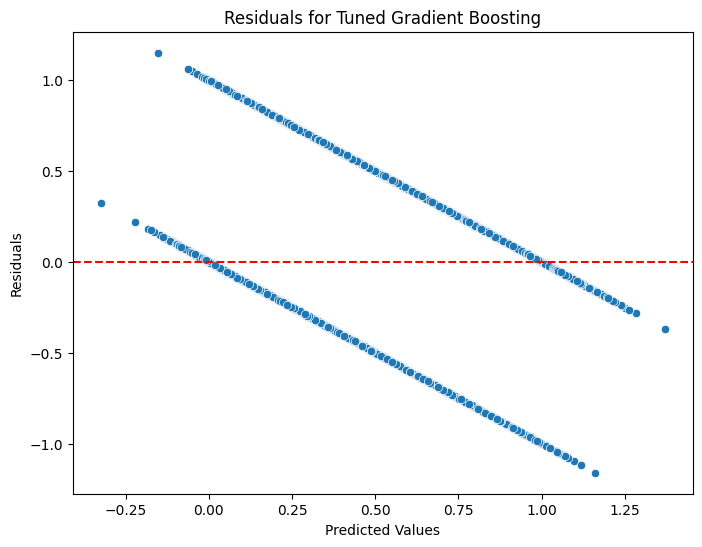

In [15]:
def plot_residuals(y_true, y_pred, title="Residual Plot"):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()

plot_residuals(y_test, y_pred_rf, title="Residuals for Tuned Random Forest")
plot_residuals(y_test, y_pred_gb, title="Residuals for Tuned Gradient Boosting")